## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

# Local imports from model.py, data.py
from model import CovidModel, Compartments, LogPoissonProb, get_logging_callbacks
from data import read_data, create_warmup
from plots import make_all_plots

2021-09-21 22:04:30.371566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-21 22:04:30.371600: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Controllable Parameters

### Data details

In [2]:
warmup_start = '20210401'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = './data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

log_dir = './logs/test_run_1'

### Model Settings

In [3]:
# How long can a person take to progress?
transition_window = 20

# CovidEstim Hyper param
T_serial = 5.8

### Vaccine efficacy for incorrect warmup data split

In [4]:
# Vaccines are 90% effective at preventing infection
# according to a study of 4000 healthcare workers in early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7013e3.htm
vax_asymp_risk = 0.90
# Vaccines are 94% effective at preventing symptomatic
# according to a study of healthcare workers in early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7020e2.htm
vax_mild_risk = 0.94
vax_extreme_risk = 0.94
# Vaccines are 94% effective at preventing hospitalization
# according to a study of adults over 65 early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7018e1.htm?s_cid=mm7018e1_w
vax_general_ward_risk = 0.94 # not used

### Model prior parameters

In [5]:
# Parameters for the Beta distribution prior over rho, the probablility that
# someone progresses to the next state. Here we use a uniform distribution
# for all compartments, but we could specify a different prior for each M, X, G

# Copied from covid estim
# covidestim infected -> symptoms
alpha_bar_M = 5.5
beta_bar_M = 3.53
# covidestim symptoms -> severe
alpha_bar_X = 1.89
beta_bar_X = 20
# covid estim severe -> death
alpha_bar_G = 28.2
beta_bar_G = 162.3

# Parameters for the positive truncated Normal distribution prior over lambda, the rate
# parameter of the Poisson distribution controlling pi,
# which determines how quickly someone who progresses does so +
# Parameters for the positive truncated Normal distribution prior over nu, the parameter used
# to scale the poisson distribution governed by pi, allowing for a more expressive
# range of possible transition days

# We choose these values to match the gamma priors in covid estim
# Covidestim infected -> symptoms = Gamma(3.41, 0.61)
lambda_bar_M = 4.7
sigma_bar_M = 1.00
nu_bar_M = 1.70
tau_bar_M = 0.10

# Covidestim Symptoms -> severe = Gamma(1.72, 0.22)
lambda_bar_X = 4
sigma_bar_X = 0.5
nu_bar_X = 18
tau_bar_X = 8.1

# Covidestim severe -> death = Gamma(2.10, 0.23)
lambda_bar_G = 3.3
sigma_bar_G = 1
nu_bar_G = 9
tau_bar_G = 0.2


# Learning rate
learning_rate = 1e-1

## Read data

In [6]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [7]:
# Optional, replace covidestim warmup data with fixed constants
#df.loc[:,'extreme'] = 7*df.loc[:,'general_ward']
#df.loc[:,'mild'] = 10*df.loc[:,'extreme']
#df.loc[:,'asymp'] = 1.5*df.loc[:,'mild']

## Create warmup using incorrect efficacy assumption

In [8]:
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          vax_asymp_risk,
                                                          vax_mild_risk,
                                                          vax_extreme_risk)

## Create training Rt and outcome

In [9]:
training_rt = df.loc[train_start:train_end,'Rt'].values
training_general_ward = df.loc[train_start:train_end,'general_ward'].values

# Start the model from the training period so we are continuous
testing_rt = df.loc[train_start:test_end,'Rt'].values
testing_general_ward = df.loc[train_start:test_end,'general_ward'].values

## Build Model

In [10]:
model = CovidModel(transition_window, T_serial,
                     alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                 lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                 nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_X, tau_bar_X)

2021-09-21 22:04:32.219212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-09-21 22:04:32.219396: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-21 22:04:32.219428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-09-21 22:04:32.219452: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-09-21 22:04:32.219473: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

## Fit model

In [11]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
)

loss = LogPoissonProb()

model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
callbacks = get_logging_callbacks(log_dir)

2021-09-21 22:04:32.260392: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 22:04:32.260423: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-21 22:04:32.260446: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-09-21 22:04:32.260591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2021-09-21 22:04:32.260639: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory
2021-09-21 22:04:32.260654: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be 

In [12]:
# Awkwardly stuff everything into an array

model.fit(x=(np.asarray([training_rt]),
       np.asarray([warmup_asymp[0]]), np.asarray([warmup_asymp[1]]),
       np.asarray([warmup_mild[0]]), np.asarray([warmup_mild[1]]),
       np.asarray([warmup_extreme[0]]), np.asarray([warmup_extreme[1]])),
             y=np.asarray([training_general_ward]),
         epochs=500, batch_size=0, callbacks=callbacks)

2021-09-21 22:04:32.316417: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2021-09-21 22:04:33.144287: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


1/1 [==============================] - 1s 1s/step - loss: 2597.2402
Epoch 2/500


2021-09-21 22:04:33.372494: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 22:04:33.372518: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-21 22:04:33.372692: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


1/1 [==============================] - ETA: 0s - loss: 2583.7292

2021-09-21 22:04:34.289467: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-21 22:04:34.290339: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-21 22:04:34.330115: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-21 22:04:34.426267: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-21 22:04:34.707093: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/test_run_1/train/plugins/profile/2021_09_21_22_04_34



1/1 [==============================] - 2s 2s/step - loss: 2583.7292


2021-09-21 22:04:34.932286: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/test_run_1/train/plugins/profile/2021_09_21_22_04_34/MrChipsNVME.trace.json.gz
2021-09-21 22:04:35.004451: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/test_run_1/train/plugins/profile/2021_09_21_22_04_34

2021-09-21 22:04:35.006522: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/test_run_1/train/plugins/profile/2021_09_21_22_04_34/MrChipsNVME.memory_profile.json.gz
2021-09-21 22:04:35.022585: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/test_run_1/train/plugins/profile/2021_09_21_22_04_34
Dumped tool data for xplane.pb to ./logs/test_run_1/train/plugins/profile/2021_09_21_22_04_34/MrChipsNVME.xplane.pb
Dumped tool data for overview_page.pb to ./logs/test_run_1/train/plugins/profile/2021_09_2

Epoch 3/500
1/1 [==============================] - 1s 852ms/step - loss: 2570.5608
Epoch 4/500
1/1 [==============================] - 1s 855ms/step - loss: 2557.1899
Epoch 5/500
1/1 [==============================] - 1s 848ms/step - loss: 2542.5793
Epoch 6/500
1/1 [==============================] - 1s 921ms/step - loss: 2525.8958
Epoch 7/500
1/1 [==============================] - 1s 847ms/step - loss: 2506.7847
Epoch 8/500
1/1 [==============================] - 1s 919ms/step - loss: 2485.0479
Epoch 9/500
1/1 [==============================] - 1s 847ms/step - loss: 2460.4141
Epoch 10/500
1/1 [==============================] - 1s 845ms/step - loss: 2432.4668
Epoch 11/500
1/1 [==============================] - 1s 851ms/step - loss: 2400.6079
Epoch 12/500
1/1 [==============================] - 1s 925ms/step - loss: 2364.0676
Epoch 13/500
1/1 [==============================] - 1s 846ms/step - loss: 2321.9268
Epoch 14/500
1/1 [==============================] - 1s 852ms/step - loss: 2273.1931

1/1 [==============================] - 1s 878ms/step - loss: 395.7454
Epoch 102/500
1/1 [==============================] - 1s 945ms/step - loss: 393.5486
Epoch 103/500
1/1 [==============================] - 1s 852ms/step - loss: 391.6086
Epoch 104/500
1/1 [==============================] - 1s 847ms/step - loss: 389.5682
Epoch 105/500
1/1 [==============================] - 1s 853ms/step - loss: 387.7205
Epoch 106/500
1/1 [==============================] - 1s 849ms/step - loss: 386.3933
Epoch 107/500
1/1 [==============================] - 1s 846ms/step - loss: 385.3242
Epoch 108/500
1/1 [==============================] - 1s 925ms/step - loss: 384.2187
Epoch 109/500
1/1 [==============================] - 1s 851ms/step - loss: 383.2862
Epoch 110/500
1/1 [==============================] - 1s 890ms/step - loss: 382.7070
Epoch 111/500
1/1 [==============================] - 1s 850ms/step - loss: 382.2222
Epoch 112/500
1/1 [==============================] - 1s 852ms/step - loss: 381.6678
Epoch 

1/1 [==============================] - 1s 915ms/step - loss: 375.4522
Epoch 199/500
1/1 [==============================] - 1s 866ms/step - loss: 375.4358
Epoch 200/500
1/1 [==============================] - 1s 851ms/step - loss: 375.4196
Epoch 201/500
1/1 [==============================] - 1s 850ms/step - loss: 375.4033
Epoch 202/500
1/1 [==============================] - 1s 853ms/step - loss: 375.3871
Epoch 203/500
1/1 [==============================] - 1s 852ms/step - loss: 375.3711
Epoch 204/500
1/1 [==============================] - 1s 915ms/step - loss: 375.3552
Epoch 205/500
1/1 [==============================] - 1s 848ms/step - loss: 375.3393
Epoch 206/500
1/1 [==============================] - 1s 848ms/step - loss: 375.3236
Epoch 207/500
1/1 [==============================] - 1s 849ms/step - loss: 375.3080
Epoch 208/500
1/1 [==============================] - 1s 849ms/step - loss: 375.2924
Epoch 209/500
1/1 [==============================] - 1s 847ms/step - loss: 375.2768
Epoch 

1/1 [==============================] - 1s 848ms/step - loss: 374.2122
Epoch 296/500
1/1 [==============================] - 1s 846ms/step - loss: 374.2025
Epoch 297/500
1/1 [==============================] - 1s 844ms/step - loss: 374.1931
Epoch 298/500
1/1 [==============================] - 1s 847ms/step - loss: 374.1835
Epoch 299/500
1/1 [==============================] - 1s 842ms/step - loss: 374.1741
Epoch 300/500
1/1 [==============================] - 1s 918ms/step - loss: 374.1649
Epoch 301/500
1/1 [==============================] - 1s 840ms/step - loss: 374.1556
Epoch 302/500
1/1 [==============================] - 1s 843ms/step - loss: 374.1461
Epoch 303/500
1/1 [==============================] - 1s 840ms/step - loss: 374.1371
Epoch 304/500
1/1 [==============================] - 1s 845ms/step - loss: 374.1280
Epoch 305/500
1/1 [==============================] - 1s 843ms/step - loss: 374.1188
Epoch 306/500
1/1 [==============================] - 1s 925ms/step - loss: 374.1097
Epoch 

1/1 [==============================] - 1s 864ms/step - loss: 373.5131
Epoch 393/500
1/1 [==============================] - 1s 858ms/step - loss: 373.5081
Epoch 394/500
1/1 [==============================] - 1s 868ms/step - loss: 373.5030
Epoch 395/500
1/1 [==============================] - 1s 936ms/step - loss: inf
Epoch 396/500
1/1 [==============================] - 1s 860ms/step - loss: inf
Epoch 397/500
1/1 [==============================] - 1s 917ms/step - loss: inf
Epoch 398/500
1/1 [==============================] - 1s 872ms/step - loss: inf
Epoch 399/500
1/1 [==============================] - 1s 920ms/step - loss: inf
Epoch 400/500
1/1 [==============================] - 1s 896ms/step - loss: inf
Epoch 401/500
1/1 [==============================] - 1s 885ms/step - loss: inf
Epoch 402/500
1/1 [==============================] - 1s 976ms/step - loss: inf
Epoch 403/500
1/1 [==============================] - 1s 893ms/step - loss: inf
Epoch 404/500
1/1 [==============================] 

1/1 [==============================] - 1s 858ms/step - loss: inf
Epoch 496/500
1/1 [==============================] - 1s 857ms/step - loss: inf
Epoch 497/500
1/1 [==============================] - 1s 924ms/step - loss: inf
Epoch 498/500
1/1 [==============================] - 1s 854ms/step - loss: inf
Epoch 499/500
1/1 [==============================] - 1s 849ms/step - loss: inf
Epoch 500/500
1/1 [==============================] - 1s 850ms/step - loss: inf


## Get predictions for train and test

In [13]:
train_preds = model((training_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0], warmup_mild[1],
       warmup_extreme[0], warmup_extreme[1]))

test_preds = model((testing_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0], warmup_mild[1],
       warmup_extreme[0], warmup_extreme[1]))
    
test_loss = loss(tf.convert_to_tensor(testing_general_ward, dtype=tf.float32), test_preds)

## Call model with special flag to get values of all internal compartments

In [14]:
forecasted_fluxes = model((testing_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0], warmup_mild[1],
       warmup_extreme[0], warmup_extreme[1]), return_all=True)

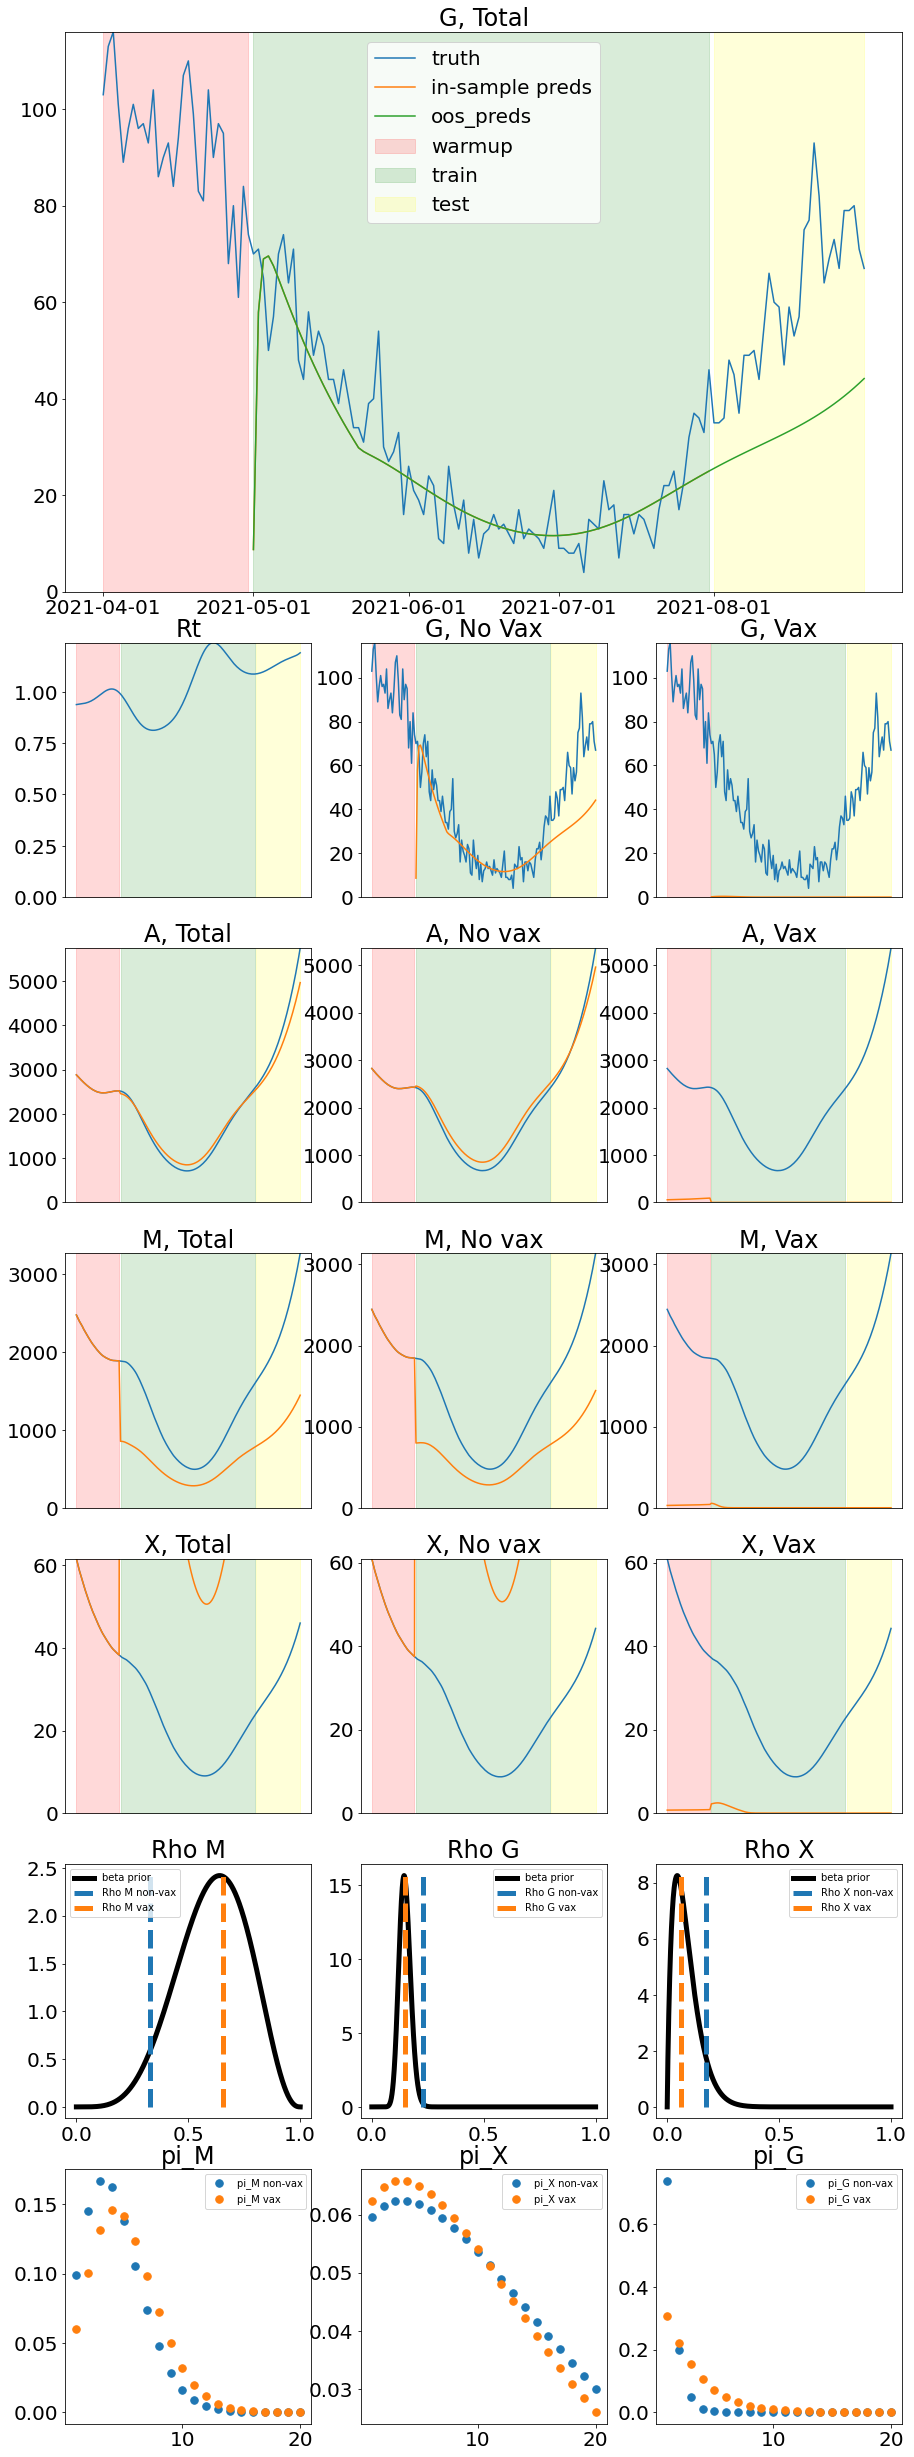

In [15]:
make_all_plots(df, model,
               alpha_bar_M, beta_bar_M,
               alpha_bar_X, beta_bar_X,
               alpha_bar_G, beta_bar_G,
                   warmup_start, warmup_end,
                   train_start, train_end,
                   test_start, test_end,
                   train_preds, test_preds,
                   vax_asymp_risk, vax_mild_risk, vax_extreme_risk,
                   forecasted_fluxes)